# Chapter 7. Optimizing and Tuning Spark Applications

## Optimizing and Tuning Spark for Efficiency

### Viewing and Setting Apache Spark Configurations

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = (SparkSession.builder
  .config("spark.sql.shuffle.partitions", 5)
  .config("spark.executor.memory", "2g")
  .master("local[*]")
  .appName("SparkTuning")
  .getOrCreate())
spark

In [ ]:
spark.conf.get("spark.sql.shuffle.partitions")

In [ ]:
spark.conf.isModifiable("spark.sql.shuffle.partitions")

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", 7)
spark.conf.get("spark.sql.shuffle.partitions")

In [ ]:
spark.conf.isModifiable("spark.executor.memory")

### Scaling Spark for Large Workloads

In [ ]:
# Setting the number of partitions for a DataFrame
df = spark.read.text("../README.md").repartition(16)

In [ ]:
df.rdd.getNumPartitions()

## Caching and Persistence of Data

In [ ]:
# This shows how caching improves performance.
dfc = spark.range(10_000_000).withColumn("square", F.expr("id * id"))
dfc.cache()  # Cache the data
%timeit -n1 -r1 dfc.count()  # Materialize the cache (slow)

In [ ]:
# Use cached data (fast)
%timeit -n1 -r1 dfc.count()

In [ ]:
# Using `persist()` instead of `cache()` allows to choose particular storage for caching, e.g., disk
dfp = spark.range(20_000_000).withColumn("square", F.expr("id * id"))
from pyspark.storagelevel import StorageLevel
dfp.persist(StorageLevel.DISK_ONLY)  # Cache the data
%timeit -n1 -r1 dfp.count()

In [ ]:
%timeit -n1 -r1 dfp.count()

In [ ]:
# Caching in Spark SQL
dfs = spark.range(30_000_000).withColumn("square", F.expr("id * id"))
dfs.createOrReplaceTempView("dfTable")
spark.sql("CACHE TABLE dfTable")
%timeit -n1 -r1 spark.sql("SELECT count(*) FROM dfTable").show()

In [ ]:
%timeit -n1 -r1 spark.sql("SELECT count(*) FROM dfTable").show()

## A Family of Spark Joins

In [ ]:
tripdelaysFilePath = "../data/departuredelays.csv"
airportsnaFilePath = "../data/airport-codes-na.txt"

# Obtain airports data set
airportsna = (spark.read
 .format("csv")
 .options(header="true", inferSchema="true", sep="\t")
 .load(airportsnaFilePath))
airportsna.createOrReplaceTempView("airports_na")

# Obtain departure delays data set
departureDelays = (spark.read
 .format("csv")
 .options(header="true")
 .load(tripdelaysFilePath))
departureDelays = (departureDelays
 .withColumn("delay", F.expr("CAST(delay as INT) as delay"))
 .withColumn("distance", F.expr("CAST(distance as INT) as distance")))
departureDelays.createOrReplaceTempView("departureDelays")

# Create temporary small table
foo = (departureDelays
 .filter(F.expr("origin == 'SEA' and destination == 'SFO' and date like '01010%' and delay > 0")))
foo.createOrReplaceTempView("foo")

# Create temporary small table
delaysSmall = (departureDelays
 .filter(F.expr("origin == 'SEA' and destination == 'SFO' and date like '01010%' and delay > 0")))
delaysSmall.createOrReplaceTempView("delaysSmall")

In [ ]:
spark.sql("SELECT * FROM airports_na LIMIT 10").show()
spark.sql("SELECT * FROM departureDelays LIMIT 10").show()
spark.sql("SELECT * FROM delaysSmall").show()

### Broadcast Hash Join


In [ ]:
joined_df = airportsna.join(F.broadcast(delaysSmall), F.expr("IATA = origin"))
joined_df.show()
joined_df.explain("extended")  # Notice 'BroadcastHashJoin' in the physical plan

### Shuffle Sort Merge Join

In [ ]:
users_df = spark.createDataFrame(zip(range(1_000_000), reversed(range(1_000_000))), schema="`uid` int, `phone` int")
orders_df = spark.createDataFrame(zip(range(1_000_000), reversed(range(1_000_000))), schema="`user_id` int, `order` int")

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
users_orders_df = orders_df.join(users_df, F.expr("user_id = uid"))
users_orders_df.show()
users_orders_df.explain("extended")  # Notice 'SortMergeJoin' in the physical plan

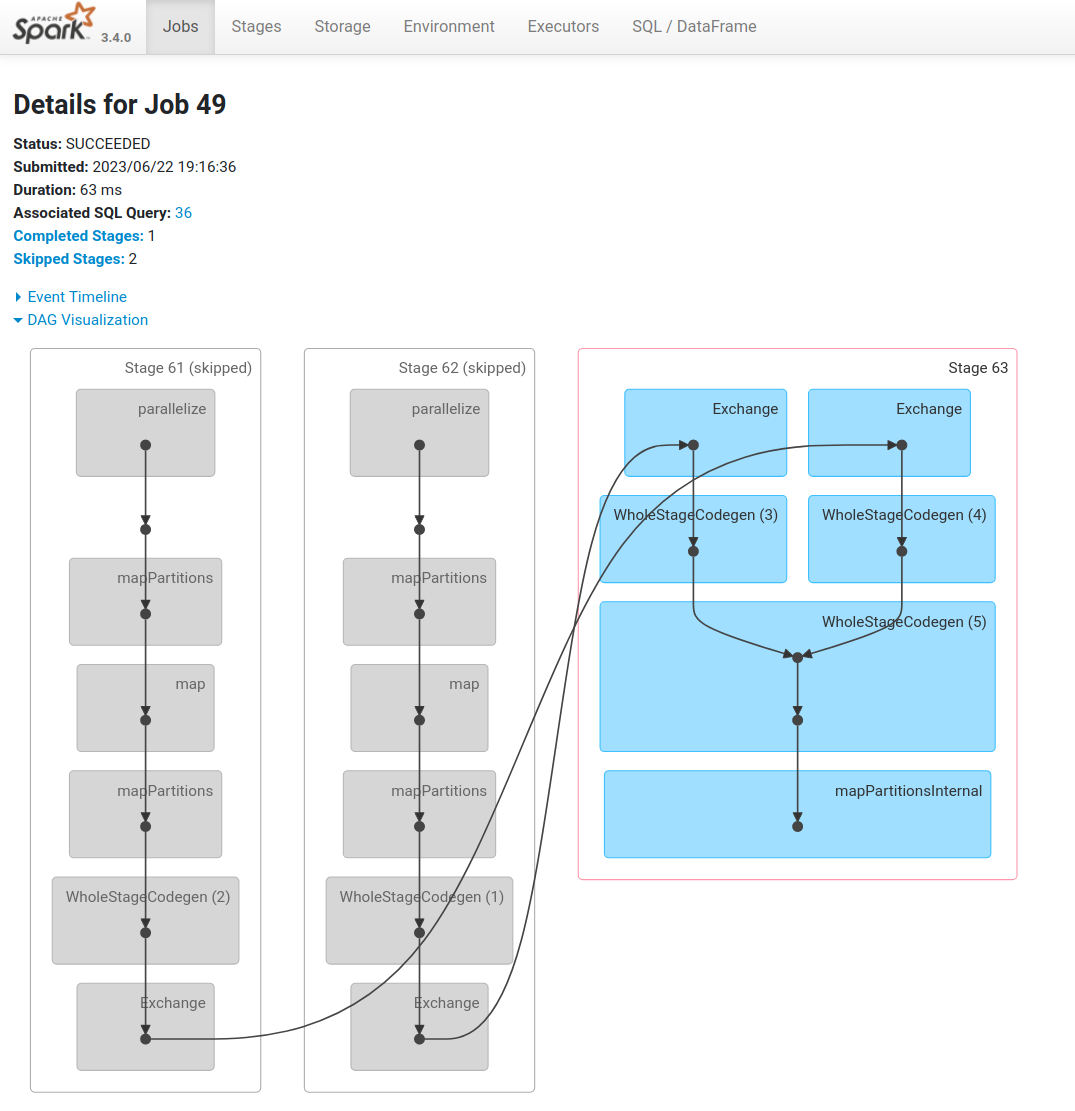

In [ ]:
# Save as managed tables by bucketing them in Parquet format
(users_df.orderBy(F.asc("uid"))
 .write.format("parquet")
 .bucketBy(8, "uid")
 .mode("overwrite")
 .saveAsTable("UsersTbl"))
(orders_df.orderBy(F.asc("user_id"))
 .write.format("parquet")
 .bucketBy(8, "user_id")
 .mode("overwrite")
 .saveAsTable("OrdersTbl"))

# Cache the tables
spark.sql("CACHE TABLE UsersTbl")
spark.sql("CACHE TABLE OrdersTbl")

# Read them back in
users_bucket_df = spark.table("UsersTbl")
orders_bucket_df = spark.table("OrdersTbl")

# Do the join and show the results
join_users_orders_bucket_df = orders_bucket_df.join(users_bucket_df, F.col("user_id") == F.col("uid"))
join_users_orders_bucket_df.show()
join_users_orders_bucket_df.explain("extended")
# Notice that there are no `Exchange` steps in the physical plan, and in the UI's DAG visualization
spark.sql("DROP TABLE IF EXISTS UsersTbl")
spark.sql("DROP TABLE IF EXISTS OrdersTbl")

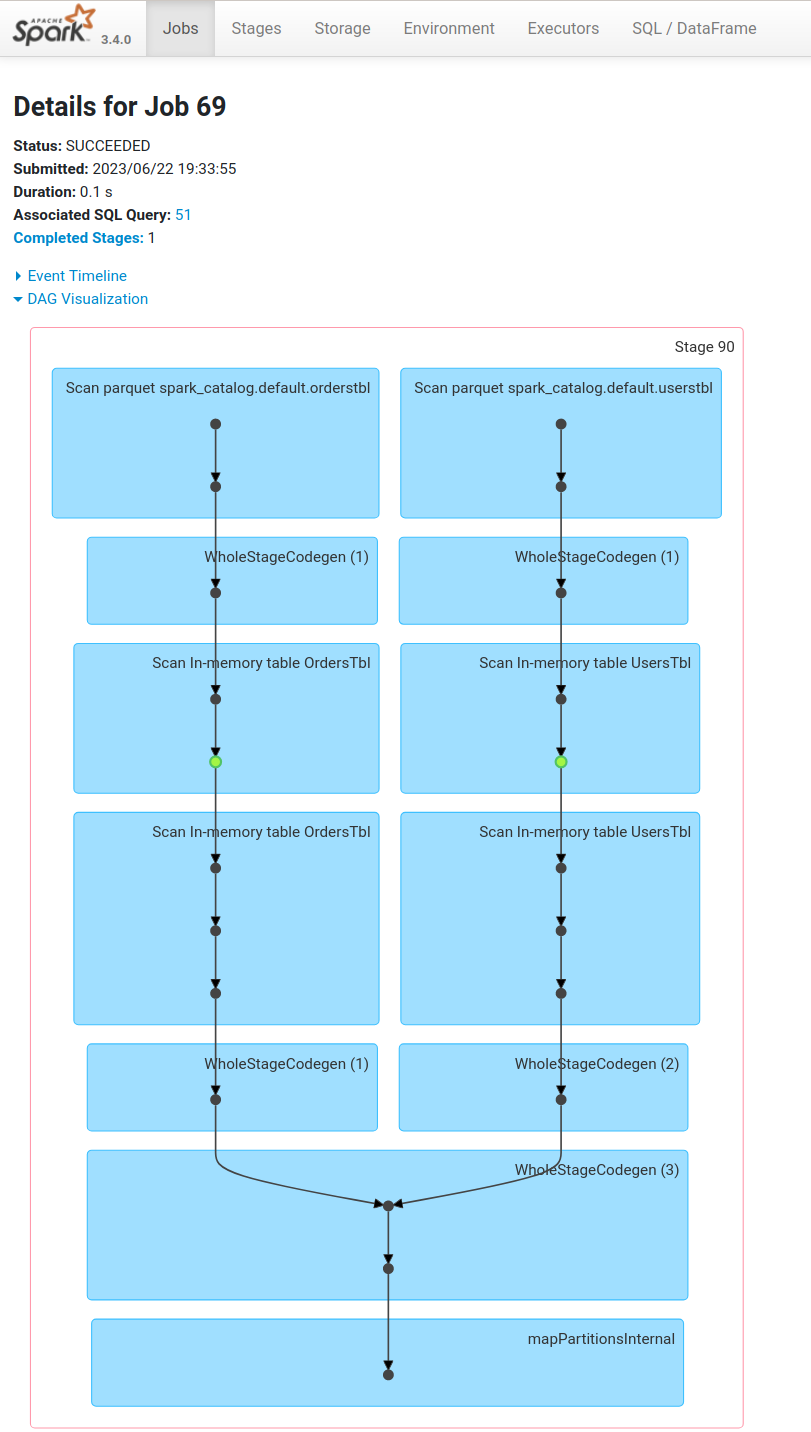